# Case 2 - Lung pneumonia classification
Neural Networks for Health Technology Applications<br>
Jori Nordlund, Mikko Iivarinen, Mikko Puustinen<br>
Helsinki Metropolia University of Applied sciences<br>
01.03.2020

## Background
The goal of this assignment is to develop and train a convolutional neural network model that will reliably identify whether a patient has lung pneumonia or not based on a x-ray image.<br>
We are going to try construct a couple different models and compare the results achieved with said models. The original data used for this assignment can be found from the following link:<br>
https://data.mendeley.com/datasets/rscbjbr9sj/2


## Imports

In [0]:
%pylab inline
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import SensitivityAtSpecificity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

Populating the interactive namespace from numpy and matplotlib


## Data handling

In [0]:
# Getting the image files and making sure no other files than "jpeg" are being used
orig_dir = './chest_xray/train'
normal_images = [x for x in os.listdir(os.path.join(orig_dir,'NORMAL')) if x.endswith(".jpeg")]
pneumonia_images = [x for x in os.listdir(os.path.join(orig_dir,'PNEUMONIA')) if x.endswith(".jpeg")]

N_NORMAL = len(normal_images) # Normal images
N_PNEUMONIA = len(pneumonia_images) # Pneumonia images
TOTAL = N_NORMAL + N_PNEUMONIA

print("Original training images:")
print(f'{N_NORMAL:5d} images of healthy patients')
print(f'{N_PNEUMONIA:5d} images of patients with pneumonia')
print(f'{TOTAL:5d} total.')

Original training images:
 1349 normal cases
 3883 pneumonia cases
 5232 total.


In [0]:
# Making separate directories for training, validation and testing
train_dir = './train'
valid_dir = './validation'
test_dir = './test'
all_dirs = [train_dir, valid_dir, test_dir]
try:
    for d in all_dirs:
        os.mkdir(d)
        os.mkdir(os.path.join(d, 'NORMAL'))
        os.mkdir(os.path.join(d, 'PNEUMONIA'))
except:
    pass
print('Training directory = ', train_dir)
print(os.listdir(train_dir))

Training directory =  ./train
['NORMAL', 'PNEUMONIA']


In [0]:
# Shuffling the images
random.shuffle(normal_images)
random.shuffle(pneumonia_images)

In [0]:
# THIS PART NEEDS TO BE EXECUTED WHEN RUN THE FIRST TIME!!!
# IT COPIES THE IMAGES FROM THE ORIGINAL DIRECTORY AND DIVIDES THEM TO THREE FOLDERS.
# THESE FOLDERS WILL BE USED LATER FOR TRAINING, VALIDATING AND TESTING.

"""
#Normal test
for fname in normal_images[:500]:
    src = os.path.join(orig_dir, 'NORMAL', fname)
    dst = os.path.join(test_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)
    
#Normal validation
for fname in normal_images[501:1001]:
    src = os.path.join(orig_dir, 'NORMAL', fname)
    dst = os.path.join(valid_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)
    
#Normal training
for fname in normal_images[1002:]:
    src = os.path.join(orig_dir, 'NORMAL', fname)
    dst = os.path.join(train_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)

#Pneumonia test
for fname in pneumonia_images[:500]:
    src = os.path.join(orig_dir, 'PNEUMONIA', fname)
    dst = os.path.join(test_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)
    
#Pneumonia validation
for fname in pneumonia_images[501:1001]:
    src = os.path.join(orig_dir, 'PNEUMONIA', fname)
    dst = os.path.join(valid_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)
    
#Pneumonia training
for fname in pneumonia_images[1002:]:
    src = os.path.join(orig_dir, 'PNEUMONIA', fname)
    dst = os.path.join(train_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)
"""

"\n#Normal test\nfor fname in normal_images[:500]:\n    src = os.path.join(orig_dir, 'NORMAL', fname)\n    dst = os.path.join(test_dir, 'NORMAL', fname)\n    shutil.copyfile(src, dst)\n    \n#Normal validation\nfor fname in normal_images[501:1001]:\n    src = os.path.join(orig_dir, 'NORMAL', fname)\n    dst = os.path.join(valid_dir, 'NORMAL', fname)\n    shutil.copyfile(src, dst)\n    \n#Normal training\nfor fname in normal_images[1002:]:\n    src = os.path.join(orig_dir, 'NORMAL', fname)\n    dst = os.path.join(train_dir, 'NORMAL', fname)\n    shutil.copyfile(src, dst)\n\n#Pneumonia test\nfor fname in pneumonia_images[:500]:\n    src = os.path.join(orig_dir, 'PNEUMONIA', fname)\n    dst = os.path.join(test_dir, 'PNEUMONIA', fname)\n    shutil.copyfile(src, dst)\n    \n#Pneumonia validation\nfor fname in pneumonia_images[501:1001]:\n    src = os.path.join(orig_dir, 'PNEUMONIA', fname)\n    dst = os.path.join(valid_dir, 'PNEUMONIA', fname)\n    shutil.copyfile(src, dst)\n    \n#Pneumoni

## Creating image data generators
These generators will feed the images in batches. The batch size used is 128.

In [0]:
ImSi = (150, 150) # Image size used
BaSi = 128 # Batch size used

print('Training images:')
tg = ImageDataGenerator(rescale=1./255)
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = ImSi,
    batch_size = BaSi,
    class_mode = 'binary')
    
print('Validation images:')
devg = ImageDataGenerator(rescale=1./255)
dev_generator = devg.flow_from_directory(
    valid_dir,
    target_size = ImSi,
    batch_size = BaSi,
    shuffle = False, # Shuffle is put equal to 'False' so that the labels and images have corresponding indices when validating
    class_mode = 'binary')
    
print('Testing images:')
testg = ImageDataGenerator(rescale=1./255)
test_generator = devg.flow_from_directory(
    test_dir,
    target_size = ImSi,
    batch_size = BaSi,
    shuffle = False, # Same reason as for the validation data
    class_mode = 'binary')

Training:
Found 3228 images belonging to 2 classes.
Validation:
Found 1000 images belonging to 2 classes.
Testing:
Found 1000 images belonging to 2 classes.


## Models
- We tried and evaluated three different models.
- All three were kind of similar in structure:
  - First 4 convolutional layers that use relu activation function and max pooling
  - Before the output layer there is a flattening layer and one or two dense layers with varying amounts of neurons
  - For the output there is a dense layer which uses the sigmoid activation
- All of the models structures can be examined below.

### Model 1


In [0]:
"""
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()
"""


"\nmodel = models.Sequential()\n\nmodel.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150, 150, 3)))\nmodel.add(layers.MaxPooling2D((2,2)))\nmodel.add(layers.Conv2D(32,(3,3), activation = 'relu'))\nmodel.add(layers.MaxPooling2D((2,2)))\nmodel.add(layers.Conv2D(32,(3,3), activation = 'relu'))\nmodel.add(layers.MaxPooling2D((2,2)))\nmodel.add(layers.Conv2D(32,(3,3), activation = 'relu'))\nmodel.add(layers.MaxPooling2D((2,2)))\nmodel.add(layers.Flatten())\nmodel.add(layers.Dense(1024, activation = 'relu'))\nmodel.add(layers.Dense(1, activation = 'sigmoid'))\n\nmodel.summary()\n"

### Model 2

In [0]:

"""

"""
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        9

### Model 3

In [0]:
"""
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()
"""


"\nmodel = models.Sequential()\n\nmodel.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150, 150, 3)))\nmodel.add(layers.MaxPooling2D((2,2)))\nmodel.add(layers.Conv2D(32,(3,3), activation = 'relu'))\nmodel.add(layers.MaxPooling2D((2,2)))\nmodel.add(layers.Conv2D(32,(3,3), activation = 'relu'))\nmodel.add(layers.MaxPooling2D((2,2)))\nmodel.add(layers.Conv2D(32,(3,3), activation = 'relu'))\nmodel.add(layers.MaxPooling2D((2,2)))\nmodel.add(layers.Flatten())\nmodel.add(layers.Dense(256, activation = 'relu'))\nmodel.add(layers.Dense(128, activation = 'relu'))\nmodel.add(layers.Dense(1, activation = 'sigmoid'))\n\nmodel.summary()\n"

## Defining the metrics

In [0]:
m = [SensitivityAtSpecificity(0.55), FalseNegatives(), FalsePositives()]

## Compiling model

In [0]:
model.compile(loss = 'binary_crossentropy',
             optimizer = optimizers.RMSprop(), # We experimented with using a quite low learning rate with the optimizer but achieved better results with the default
              #optimizer = optimizers.RMSprop(lr = 1e-4)
              metrics = m # 'm' refers to the metrics defined in the block above
             )

## Fitting data to the model

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = None, # Value assigned to 'None' so all of the training data is run through automatically
    verbose = 0,
    epochs = 15,
    validation_data = dev_generator,
    validation_steps = None) # Value assigned to 'None' so all of the validation data is run through automatically

# model.save('Case_2_model_1.h10')
# This was used to save the trained models locally



# Plotting the training results

## Sensitivity at specificity
Sensitivity at specificity per epoch

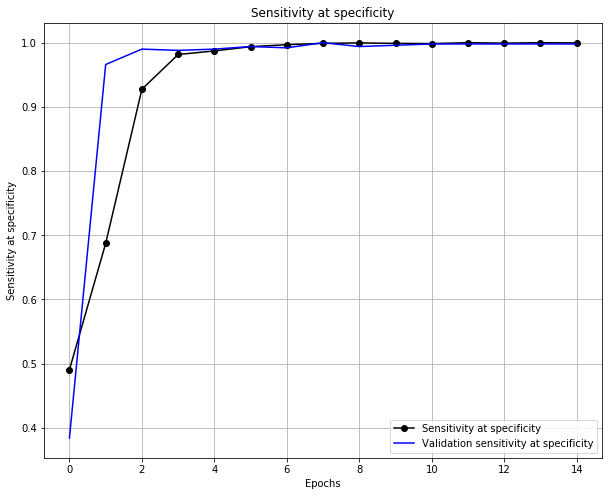

In [0]:
sas = history.history['sensitivity_at_specificity'] #save history to variable
val_sas = history.history['val_sensitivity_at_specificity']
epochs = range(len(sas)) #read the amount of epochs

plt.figure(figsize=(10,8)) #plot figure size
plt.plot(epochs, sas, '-ok', label='Sensitivity at specificity')
plt.plot(epochs, val_sas, 'b', label='Validation sensitivity at specificity')

plt.title('Sensitivity at specificity') #diagramm title
plt.xlabel('Epochs') #label for X in diagramm
plt.ylabel('Sensitivity at specificity') #label for Y in diagramm

plt.grid() #draw grid to make reading easier
plt.legend()
plt.show()

## False positives
False positives per epoch

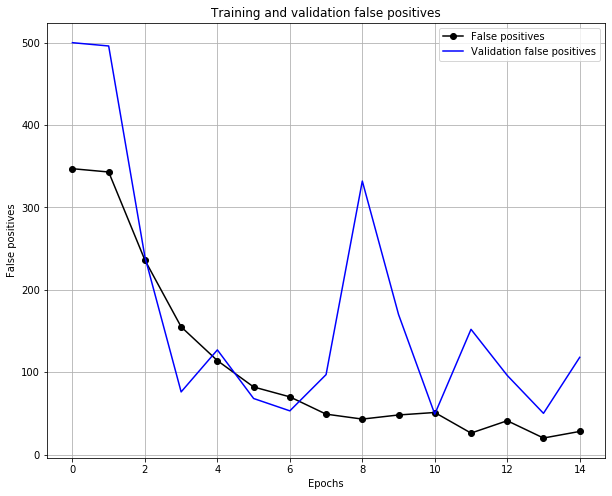

In [0]:
fpo = history.history['false_positives']
val_fpo = history.history['val_false_positives']
epochs = range(len(fpo))

plt.figure(figsize=(10,8))
plt.plot(epochs, fpo, '-ok', label='False positives')
plt.plot(epochs, val_fpo, 'b', label='Validation false positives')

plt.title('Training and validation false positives')
plt.xlabel('Epochs')
plt.ylabel('False positives')

plt.grid()
plt.legend()
plt.show()

## False negatives
False negatives per epoch

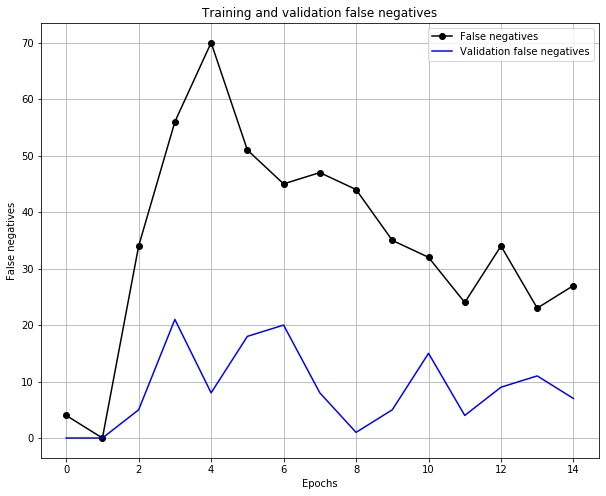

In [0]:
fane = history.history['false_negatives']
val_fane = history.history['val_false_negatives']
epochs = range(len(fane))

plt.figure(figsize=(10,8))
plt.plot(epochs, fane, '-ok', label='False negatives')
plt.plot(epochs, val_fane, 'b', label='Validation false negatives')

plt.title('Training and validation false negatives')
plt.xlabel('Epochs')
plt.ylabel('False negatives')

plt.grid()
plt.legend()
plt.show()

## Loss
Loss per epoch

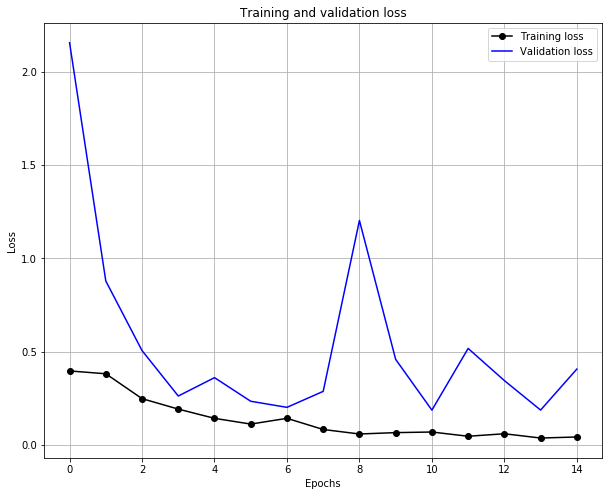

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(epochs, loss, '-ok', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid()
plt.legend()
plt.show()

# Testing the model with test data

In [0]:
# Loading the saved models
model_1 = tf.keras.models.load_model('Case_2_model_1.h10')
model_2 = tf.keras.models.load_model('Case_2_model_2.h10')
model_3 = tf.keras.models.load_model('Case_2_model_3.h10')

In [0]:
# Running the test data through each of our models and saving the predicted values
predicted_1 = model_1.predict_generator(test_generator).flatten()
predicted_2 = model_2.predict_generator(test_generator).flatten()
predicted_3 = model_3.predict_generator(test_generator).flatten()
labels = test_generator.classes # Saving the actual values of test data as 'labels'

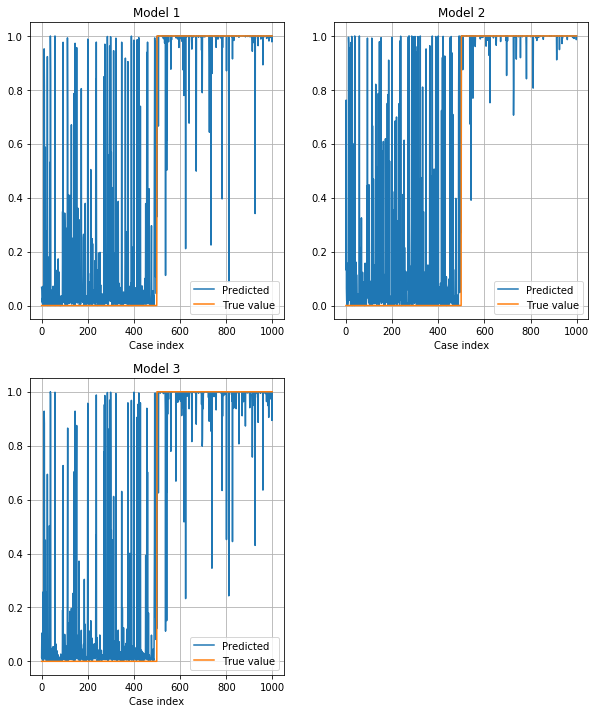

In [0]:
# Plotting how the models performed predicting whether the patient has pneumonia or not
plt.figure(figsize=(10,12))

# Model 1
subplot(2,2,1)
title('Model 1')
plot(predicted_1, label='Predicted')
plot(labels, label='True value')
grid()
legend()
xlabel('Case index')

# Model 2
subplot(2,2,2)
title('Model 2')
plot(predicted_2, label='Predicted')
plot(labels, label='True value')
grid()
legend()
xlabel('Case index')

# Model 3
subplot(2,2,3)
title('Model 3')
plot(predicted_3, label='Predicted')
plot(labels, label='True value')
grid()
legend()
xlabel('Case index')

plt.show()

## Confusion matrices
- Below are the confusion matrices for all of the models' predictions
- Attributes:
  - True negative as tn
  - False positive as fp
  - False negative as fn
  - True positive as tp

### Model 1
Model 1 performed very well finding the patients with pneumonia and the amount of false positives was relatively small.

In [0]:
tn, fp, fn, tp = confusion_matrix(labels, predicted_1 > 0.5).ravel()

print("Confusion matrix:\n", array([[tp, fn],[fp, tn]]))

Confusion matrix:
 [[493   7]
 [ 50 450]]


### Model 2
Model 2 performed extremely well in the aspect of recognizing the pneumonia on a patient. However it was quite too sensible to predict healthy persons to have pneumonia.

In [0]:
tn, fp, fn, tp = confusion_matrix(labels, predicted_2 > 0.5).ravel()

print("Confusion matrix:\n", array([[tp, fn],[fp, tn]]))


Confusion matrix:
 [[499   1]
 [ 80 420]]


### Model 3
Model 3 also worked really well recognizing pneumonia on a patient, in this aspect it performed slightly worse than model 1 (Even though the difference in false negatives is only one). However model 3 got the least predictions wrong when it comes to the false positives. 

In [0]:
tn, fp, fn, tp = confusion_matrix(labels, predicted_3 > 0.5).ravel()

print("Confusion matrix:\n", array([[tp, fn],[fp, tn]]))

Confusion matrix:
 [[492   8]
 [ 44 456]]


## Classification report
- Classification reports for our models.
- All three models performed really well on predicting whether a patient has a pneumonia or not. The recall scores were respectively: <br>
  - 100% for Model 2
  - 99% for Model 1
  - 98% for Model 3

### Model 1

In [0]:
classreport = classification_report(labels, predicted_1 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(classreport)

               precision    recall  f1-score   support

   Normal (0)       0.98      0.90      0.94       500
Pneumonia (1)       0.91      0.99      0.95       500

     accuracy                           0.94      1000
    macro avg       0.95      0.94      0.94      1000
 weighted avg       0.95      0.94      0.94      1000



### Model 2

In [0]:
classreport = classification_report(labels, predicted_2 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(classreport)

               precision    recall  f1-score   support

   Normal (0)       1.00      0.84      0.91       500
Pneumonia (1)       0.86      1.00      0.92       500

     accuracy                           0.92      1000
    macro avg       0.93      0.92      0.92      1000
 weighted avg       0.93      0.92      0.92      1000



### Model 3

In [0]:
classreport = classification_report(labels, predicted_3 > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(classreport)

               precision    recall  f1-score   support

   Normal (0)       0.98      0.91      0.95       500
Pneumonia (1)       0.92      0.98      0.95       500

     accuracy                           0.95      1000
    macro avg       0.95      0.95      0.95      1000
 weighted avg       0.95      0.95      0.95      1000



## ROC curve and threshold analysis
- False positive rate as "fpr"
- True positive rate as "tpr"


### Model 1

In [0]:
fpr, tpr, thresholds = roc_curve(labels, predicted_1, pos_label = 1) 
#roc curve = receiver operating characteristic curve, plotted tpr vs. fpr

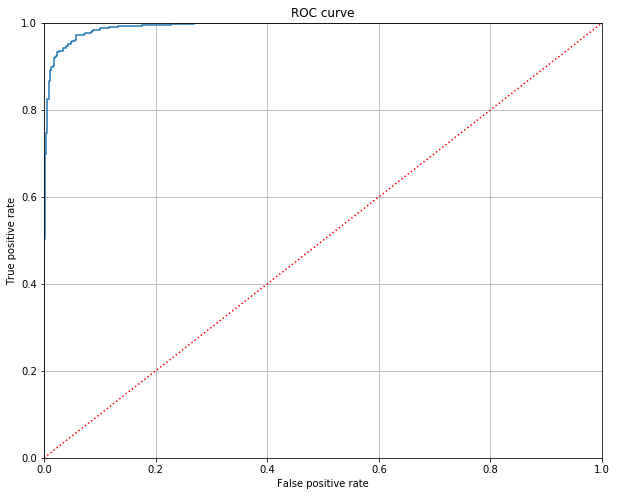

In [0]:
plt.figure(figsize=(10,8))
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:') #draw baseline from (0,0) to (1,1)
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

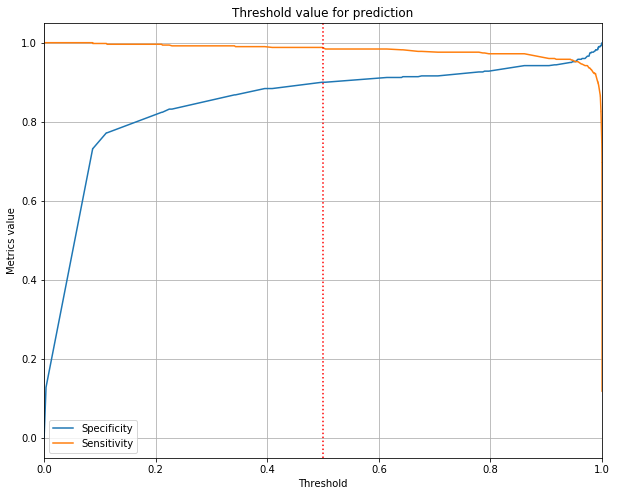

In [0]:
plt.figure(figsize=(10,8))
plot(thresholds, 1-fpr, label='Specificity')
plot(thresholds, tpr, label='Sensitivity')
axvline(0.5, color='red', linestyle=':') #threshold line 
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

### Model 2

In [0]:
fpr, tpr, thresholds = roc_curve(labels, predicted_2, pos_label = 1)

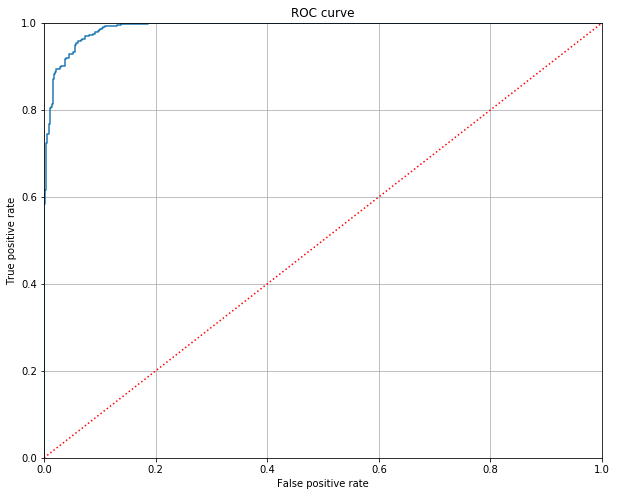

In [0]:
plt.figure(figsize=(10,8))
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

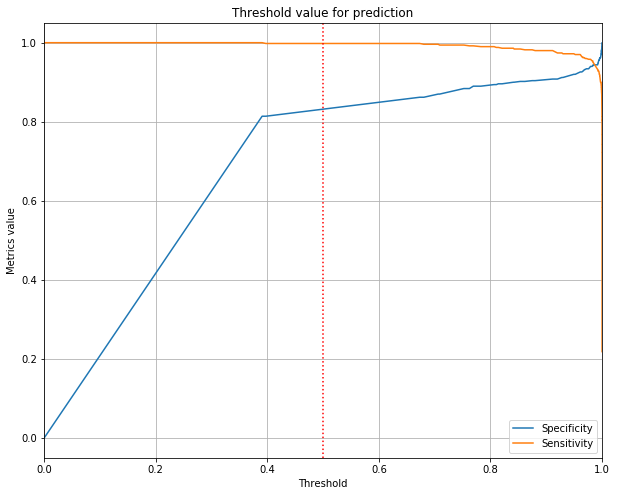

In [0]:
plt.figure(figsize=(10,8))
plot(thresholds, 1-fpr, label='Specificity')
plot(thresholds, tpr, label='Sensitivity')
axvline(0.5, color='red', linestyle=':')
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

### Model 3

In [0]:
fpr, tpr, thresholds = roc_curve(labels, predicted_3, pos_label = 1)

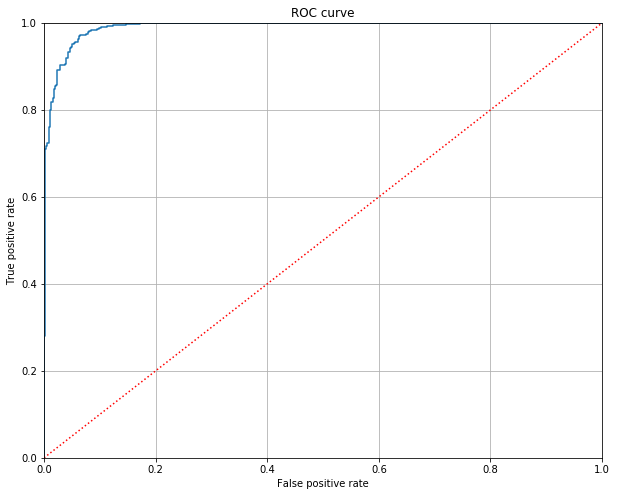

In [0]:
plt.figure(figsize=(10,8))
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

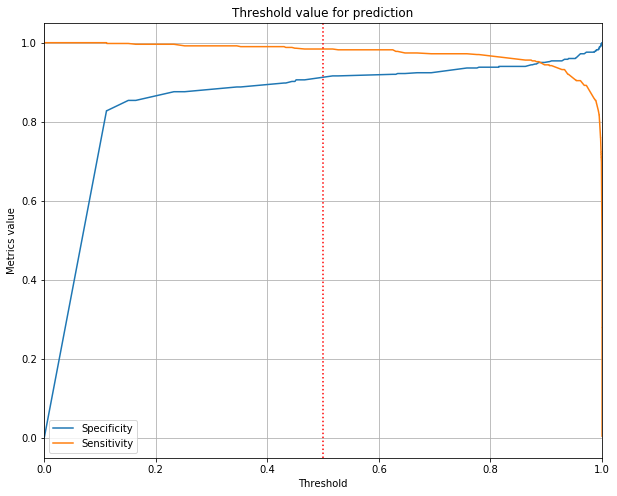

In [0]:
plt.figure(figsize=(10,8))
plot(thresholds, 1-fpr, label='Specificity')
plot(thresholds, tpr, label='Sensitivity')
axvline(0.5, color='red', linestyle=':')
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

## Results

When comparing these three models, they all have their good and bad sides.
- Model 3 has the worst recall, though the difference is very small
- Model 3 has the smallest amount of false results
<br><br>
- Model 2 has the lowest amount of false negatives, which we considered the most important faction
- Model 2 has the highest amount of false positives which lowers the accuracy (specificity) of said network, but we didn't consider false positives being as dangerous as false negatives
<br><br>
- Model 1 is kind of in between, it has less false negatives than Model 3, and less false positives than Model 2 

## Conclusion

In conclusion we think that the Model 3 is the best, because it is the most accurate with the smallest amount of false results based on confusion matrix data.<br>
Classification report also shows that Model 3 has the best results on average, though its' recall (true positive rate) isn't as high as Model 2 has.